<a href="https://colab.research.google.com/github/multikokoiti1998/vgg_8_3/blob/ResNext/ResNext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install albumentations

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
from tqdm import tqdm
import random
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision
from PIL import Image
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torch.utils.data import Dataset
from pathlib import Path
from typing import List, Tuple
from pathlib import Path
import xml.etree.ElementTree as ET
import torchvision.models as models
import torch.optim as optim
import albumentations as A
from sklearn.metrics import classification_report

In [17]:
# 画像ディレクトリと画像パスの取得
image_directory = '/content/drive/MyDrive/lernig/obiref88/image'
label_directory = '/content/drive/MyDrive/lernig/obiref88/label'

def update_xml_paths(image_directory: str, label_directory: str):
    image_paths = []
    labels = []

    # 画像ファイルとXMLファイルの一致確認
    for image_file in os.listdir(image_directory):
        if image_file.endswith('.jpg'):
            base_name = image_file.replace('.jpg', '')

            xml_path = Path(label_directory) / f"{base_name}.xml"

            if xml_path.exists():
                tree = ET.parse(xml_path)
                root = tree.getroot()
                label = root.find('.//name')
                image_paths.append(os.path.join(image_directory, image_file))
                labels.append(label.text)

    return image_paths, labels

image_paths, labels = update_xml_paths(image_directory, label_directory)
print("Number of image paths:", len(image_paths))
print("Number of labels:", len(labels))


Number of image paths: 300
Number of labels: 300


In [18]:
data_transform = {
    'train': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
         transforms.RandomRotation(degrees=[-5, 5]),
         transforms.ColorJitter(brightness=0.3, contrast=0.5),
         #A.GaussNoise(var_limit=(10, 50))transformライブラリでないので変換前後で定義しなおさなくてはならない,
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ]),
    'val': transforms.Compose(
        [transforms.Resize((256, 256)),
         transforms.CenterCrop(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.35187622, 0.35187622, 0.35187622],
                              std=[0.33888655, 0.33888655, 0.33888655]),
         ])
}



In [19]:
label_mapping = {
    'ok': 0,
    'out': 1
}
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label_mapping[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert('RGB')
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
            label=torch.tensor(label)
        return image, label


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
num_epochs=200
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_dataset=[]
val_dataset=[]
total_train_accs=[]
total_val_accs=[]
data_size = {'train': len(train_dataset), 'val': len(val_dataset)}

In [22]:
def train_model(model, criterion, optimizer, num_epochs):

        for epoch in range(num_epochs):
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / data_size[phase]
                epoch_acc = corrects.double() / data_size[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc)
                    print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              #print('{}Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        train_accs_cpu = [acc.cpu().numpy() for acc in train_accs]
        val_accs_cpu = [acc.cpu().numpy() for acc in val_accs]

        plot_training_history(train_losses, val_losses, train_accs_cpu, val_accs_cpu)



def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    # Lossのプロット
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracyのプロット
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accs, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4, 1)
    plt.tight_layout()
    plt.show()


In [23]:
net = models.resnext50_32x4d(pretrained=True)

#for param in net.parameters():
          #param.requires_grad = False

# モデルをGPUに移動

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# 損失関数と最適化アルゴリズムを定義(MSE）
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
# モデルのトレーニングと評価
model = net
base_path = r'/content/drive/MyDrive/learning'
folder_name = 'weight'
directory_path = os.path.join(base_path, folder_name)
file_name = 'alexnet.pth'
file_path = os.path.join(base_path, folder_name, file_name)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 206MB/s]


In [24]:
print("Length of image_paths:", len(image_paths))
print("Length of labels:", len(labels))

Length of image_paths: 300
Length of labels: 300


==========Cross Validation Fold 1==========
trainLoss: 0.5892 Acc: 0.7500
valLoss: 0.6078 Acc: 0.7500
trainLoss: 0.5886 Acc: 0.7500
valLoss: 0.5902 Acc: 0.7667
trainLoss: 0.5718 Acc: 0.7583
valLoss: 0.5769 Acc: 0.7500
trainLoss: 0.5801 Acc: 0.7458
valLoss: 0.5840 Acc: 0.7500
trainLoss: 0.5628 Acc: 0.7583
valLoss: 0.5712 Acc: 0.7500
trainLoss: 0.5523 Acc: 0.7667
valLoss: 0.5613 Acc: 0.7500
trainLoss: 0.5491 Acc: 0.7917
valLoss: 0.5718 Acc: 0.7500
trainLoss: 0.5419 Acc: 0.7833
valLoss: 0.5592 Acc: 0.7833
trainLoss: 0.5391 Acc: 0.7875
valLoss: 0.5566 Acc: 0.7833
trainLoss: 0.5313 Acc: 0.8042
valLoss: 0.5561 Acc: 0.8000
trainLoss: 0.5262 Acc: 0.7958
valLoss: 0.5754 Acc: 0.7667
trainLoss: 0.5294 Acc: 0.8125
valLoss: 0.5700 Acc: 0.7500
trainLoss: 0.5235 Acc: 0.8042
valLoss: 0.5420 Acc: 0.8000
trainLoss: 0.5177 Acc: 0.8125
valLoss: 0.5485 Acc: 0.8000
trainLoss: 0.5090 Acc: 0.8333
valLoss: 0.5670 Acc: 0.7500
trainLoss: 0.5101 Acc: 0.8292
valLoss: 0.5453 Acc: 0.8000
trainLoss: 0.4915 Acc: 0.854

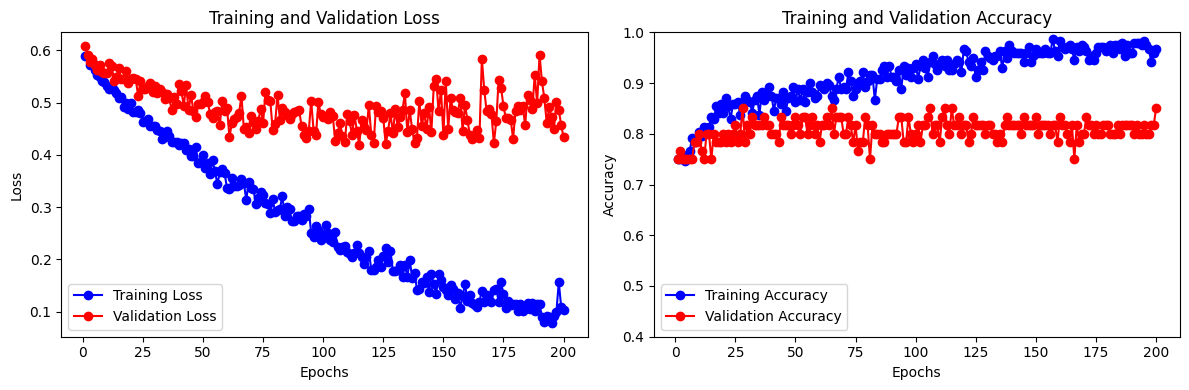

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.86      0.96      0.91        45
         out       0.80      0.53      0.64        15

    accuracy                           0.85        60
   macro avg       0.83      0.74      0.77        60
weighted avg       0.85      0.85      0.84        60

==========Cross Validation Fold 2==========
trainLoss: 0.7071 Acc: 0.4250
valLoss: 0.7120 Acc: 0.2833
trainLoss: 0.6215 Acc: 0.6708
valLoss: 0.6664 Acc: 0.3667
trainLoss: 0.5661 Acc: 0.7542
valLoss: 0.5790 Acc: 0.7500
trainLoss: 0.5210 Acc: 0.8208
valLoss: 0.5246 Acc: 0.7833
trainLoss: 0.4990 Acc: 0.8167
valLoss: 0.4824 Acc: 0.8500
trainLoss: 0.4659 Acc: 0.8625
valLoss: 0.4400 Acc: 0.8667
trainLoss: 0.4238 Acc: 0.8917
valLoss: 0.3918 Acc: 0.8833
trainLoss: 0.4018 Acc: 0.8917
valLoss: 0.3544 Acc: 0.9000
trainLoss: 0.3811 Acc: 0.8958
valLoss: 0.3480 Acc: 0.9000
trainLoss: 0.3445 Acc: 0.9292
valLoss: 0.3149 Acc: 0.9167
trainLoss: 0.3566 Acc: 0

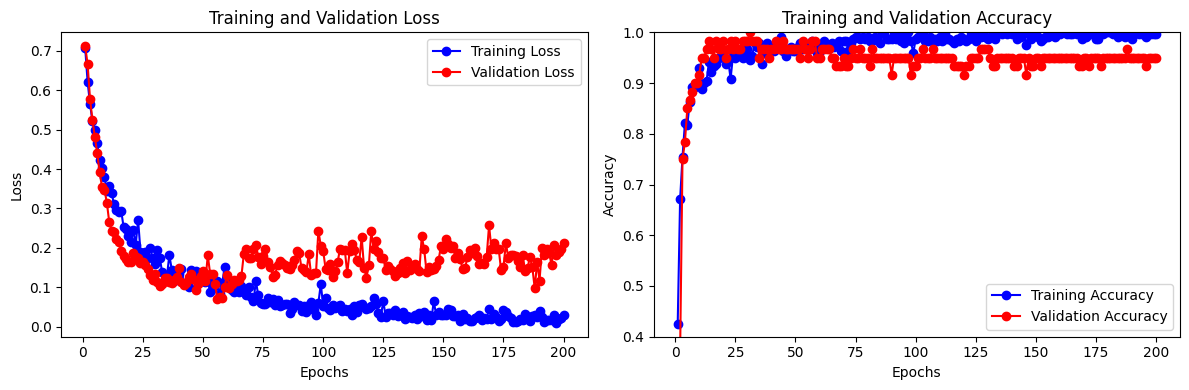

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      0.96      0.97        45
         out       0.88      0.93      0.90        15

    accuracy                           0.95        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.95      0.95      0.95        60

==========Cross Validation Fold 3==========
trainLoss: 0.5504 Acc: 0.9000
valLoss: 0.5625 Acc: 0.6333
trainLoss: 0.3817 Acc: 0.9875
valLoss: 0.4432 Acc: 0.9500
trainLoss: 0.3071 Acc: 0.9792
valLoss: 0.3386 Acc: 1.0000
trainLoss: 0.2537 Acc: 0.9750
valLoss: 0.2488 Acc: 1.0000
trainLoss: 0.2275 Acc: 0.9792
valLoss: 0.1896 Acc: 1.0000
trainLoss: 0.1917 Acc: 0.9750
valLoss: 0.1620 Acc: 1.0000
trainLoss: 0.1735 Acc: 0.9750
valLoss: 0.1299 Acc: 1.0000
trainLoss: 0.1650 Acc: 0.9750
valLoss: 0.1167 Acc: 1.0000
trainLoss: 0.1595 Acc: 0.9792
valLoss: 0.1094 Acc: 1.0000
trainLoss: 0.1356 Acc: 0.9792
valLoss: 0.0941 Acc: 1.0000
trainLoss: 0.1180 Acc: 0

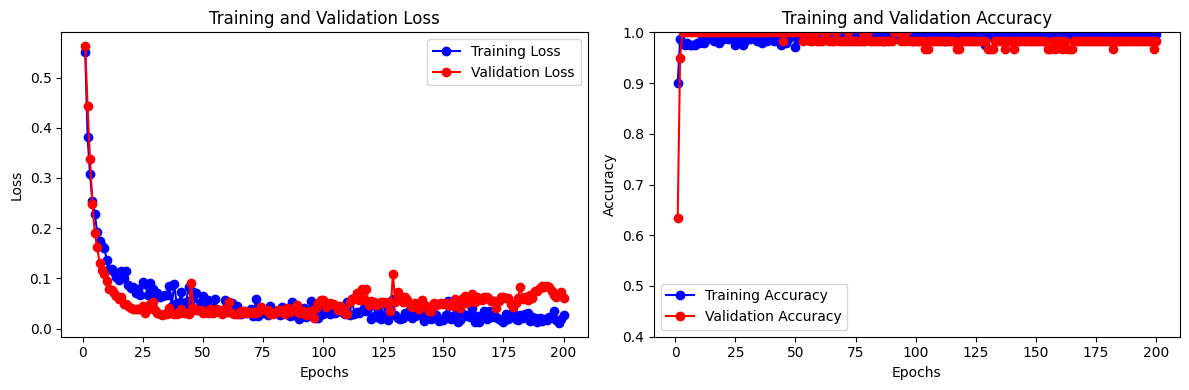

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       0.98      1.00      0.99        45
         out       1.00      0.93      0.97        15

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60

==========Cross Validation Fold 4==========
trainLoss: 0.6994 Acc: 0.3875
valLoss: 0.7627 Acc: 0.2500
trainLoss: 0.4883 Acc: 0.9500
valLoss: 0.6086 Acc: 0.2833
trainLoss: 0.3730 Acc: 0.9875
valLoss: 0.4655 Acc: 0.9167
trainLoss: 0.2911 Acc: 0.9792
valLoss: 0.3445 Acc: 1.0000
trainLoss: 0.2494 Acc: 0.9833
valLoss: 0.2668 Acc: 1.0000
trainLoss: 0.2107 Acc: 0.9875
valLoss: 0.2007 Acc: 1.0000
trainLoss: 0.1851 Acc: 0.9875
valLoss: 0.1704 Acc: 1.0000
trainLoss: 0.1674 Acc: 0.9875
valLoss: 0.1443 Acc: 1.0000
trainLoss: 0.1464 Acc: 0.9958
valLoss: 0.1263 Acc: 1.0000
trainLoss: 0.1255 Acc: 0.9917
valLoss: 0.1036 Acc: 1.0000
trainLoss: 0.1220 Acc: 0

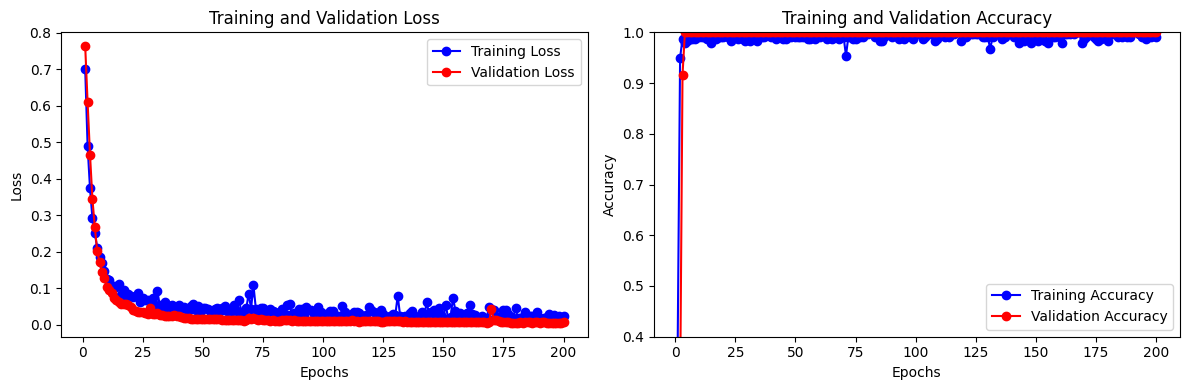

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       1.00      1.00      1.00        45
         out       1.00      1.00      1.00        15

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60

==========Cross Validation Fold 5==========
trainLoss: 0.4922 Acc: 0.8417
valLoss: 0.4331 Acc: 1.0000
trainLoss: 0.3191 Acc: 0.9792
valLoss: 0.3160 Acc: 1.0000
trainLoss: 0.2431 Acc: 0.9917
valLoss: 0.2173 Acc: 1.0000
trainLoss: 0.1819 Acc: 0.9958
valLoss: 0.1621 Acc: 1.0000
trainLoss: 0.1498 Acc: 0.9958
valLoss: 0.1240 Acc: 1.0000
trainLoss: 0.1427 Acc: 0.9958
valLoss: 0.1010 Acc: 1.0000
trainLoss: 0.1235 Acc: 0.9958
valLoss: 0.0832 Acc: 1.0000
trainLoss: 0.1060 Acc: 1.0000
valLoss: 0.0691 Acc: 1.0000
trainLoss: 0.0918 Acc: 0.9917
valLoss: 0.0616 Acc: 1.0000
trainLoss: 0.0872 Acc: 0.9917
valLoss: 0.0522 Acc: 1.0000
trainLoss: 0.0949 Acc: 0

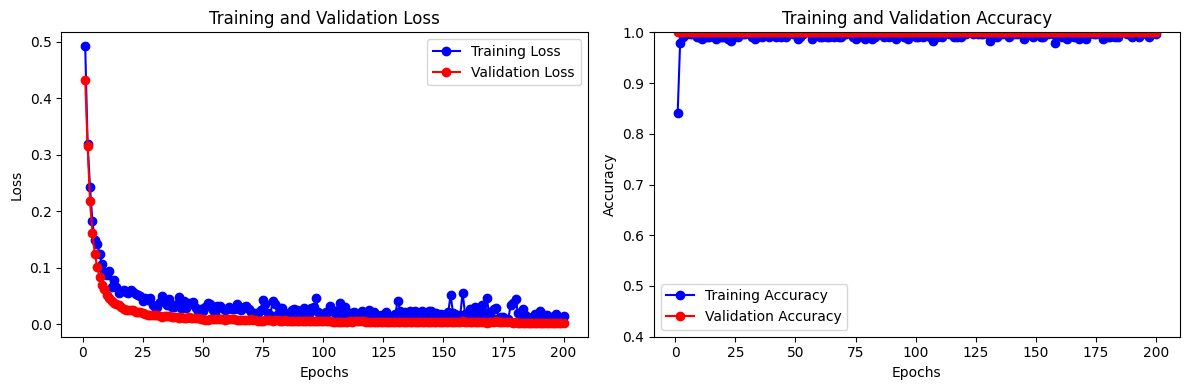

Train done.
Train saved.
              precision    recall  f1-score   support

          ok       1.00      1.00      1.00        46
         out       1.00      1.00      1.00        14

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [26]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# データセットの分割とデータローダーの作成
for fold, (train_index, val_index) in enumerate(kfold.split(image_paths,labels), 1):
    print(f'==========Cross Validation Fold {fold}==========')
    image_directory = '/content/drive/MyDrive/lernig/OBI_ref/image'
    label_directory = '/content/drive/MyDrive/lernig/OBI_ref/label'


    image_paths, labels = update_xml_paths(image_directory, label_directory)
    train_paths = [image_paths[i] for i in train_index]
    train_labels = [labels[i] for i in train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = [labels[i] for i in val_index]

    train_dataset = ImageDataset(train_paths, train_labels, transform=data_transform['train'])
    val_dataset = ImageDataset(val_paths, val_labels, transform=data_transform['val'])

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    dataloaders  = {"train":train_loader, "val":val_loader}

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # 事前学習済みモデルの全結合層の出力ユニット数をデータのクラス数に置き換え
    num_classes = len(set(train_labels))
    net.fc = nn.Linear(net.fc.in_features, num_classes)

# ここでデータローダーを使用して学習や検証を行う
    data_size = {'train': len(train_dataset), 'val': len(val_dataset)}
    train_model(model, criterion, optimizer, num_epochs)
    print('Train done.')
    file_path = os.path.join(directory_path, f'{file_name}_{str(fold)}.pth')
    # モデルの保存
    torch.save(model.state_dict(), file_path)
    print('Train saved.')
    model.load_state_dict(torch.load(file_path))
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          y_pred.extend(predicted.cpu().numpy())
          y_true.extend(labels.cpu().numpy())

    # 評価
    target_names = ['ok', 'out']  # クラス名をリストで指定
    print(classification_report(y_true, y_pred, target_names=target_names))